In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns


# PMFs, PDFs, CDFs and All That

Alphabet soup? Kinda. But these are the terms that are used in the business, so get used to it!

When dealing with random events and measurements it's important to be clear about the kinds of things that can happen and their relative likelihood. These concepts (PMF, PDF, CDF) help to understand and clarify the relationships between the many different ways things can be "random".

Let's start with the simplest cases: discrete events. This would be things like the roll of a die, or the flipping of a coin. In each case the outcome is one of a countable set of possible states (e.g., heads, tails, 1, 2, ... 6). Each of these outcomes may have a different probability. The distribution of probabilities among the outcomes is the "Probability Mass Function (PMF)".

For a fair coin, the probability mass function would be simply:

* Heads: 0.5
* Tails: 0.5

It's just a list of the possible outcomes, along with the probability of each. We can use the probability mass function to estimate the likelihood of various possibilities. 

## Example:

Since the simplest example of a PMF is the probability of a flipped coin landing on "heads" or "tails" we can work out the chances of seeing a certain number of heads or tails in a series of coin flipping experiments. Suppose we have a coin and we're not *sure* if it's fair. Let's flip it a bunch of times and see how many heads and tails we get. Can we tell from the number of heads and tails whether the coin is fair? To help us think about this I've cooked up a python function that flips coins using the built-in random number generator:


In [2]:
def flipCoins(N, p=0.5):
    """
    Simulate flipping a coin N times. Return the number of "heads". If p is not specified,
    the probability of "heads" on any given flip is 50%. Otherwise, the probability of "heads"
    is p.
    """
    return (np.random.rand(N)<p).sum()

print("flip 100 coins, Nheads = ", flipCoins(100))
print("flip 1000 coins, Nheads = ", flipCoins(1000))
print("flip 10000 coins, Nheads = ", flipCoins(10000))
print("flip 100000 coins, Nheads = ", flipCoins(100000))

flip 100 coins, Nheads =  46
flip 1000 coins, Nheads =  508
flip 10000 coins, Nheads =  4991
flip 100000 coins, Nheads =  49852


Of course, every time you run this cell, you'll get slightly different results (since flipping a coin is, after all, random!). However you should notice that the larger the number of flips the smaller the *relative* deviation from the "fair coin" result. Can we quantify this? Sure! Let's do an experiment. Flip N coins, over and over, and compute the fraction of the time we get heads. To make this work we need to use a python *dictionary* which is a simple database of key-value pairs. In this case the "key" will be the number of heads, and the value will be a *count* of the number of times we got that number of heads.

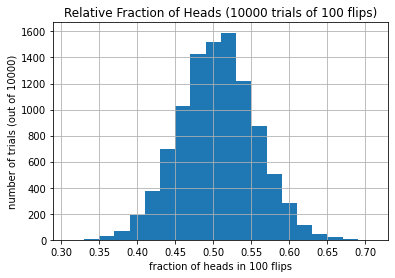

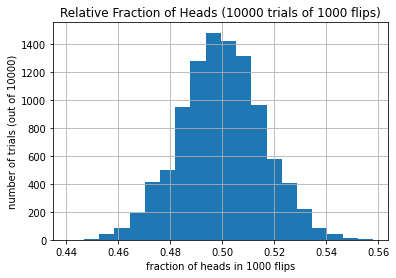

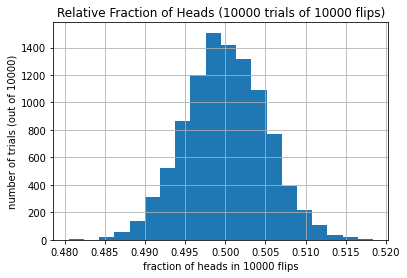

In [3]:
def buildAFlippingHistogram(M, N=100, p=0.5):
    """
    Flip N coins M times and create a histogram of the fraction of flips that are "heads"
    """
    
    results=[]
    
    for i in range(M):
        results.append(flipCoins(N,p)/N)

    pl.figure()
    pl.hist(results,20)
    pl.title("Relative Fraction of Heads ({0} trials of {1} flips)".format(M, N))
    pl.xlabel("fraction of heads in {0} flips".format(N))
    pl.ylabel("number of trials (out of {0})".format(M))
    pl.grid()
    
    

#
# Let's create 3 histograms with 100, 1000, and 10000 trials
#

buildAFlippingHistogram(10000,100,0.5)
buildAFlippingHistogram(10000,1000,0.5)
buildAFlippingHistogram(10000,10000,0.5)
    

An alternative to histograms is a "Kernel Density Estimator", which provides a more continuous represnetation of the probability distribution of the samples. See below

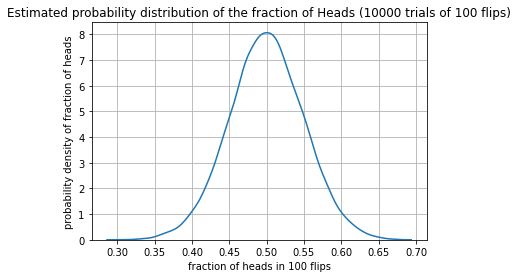

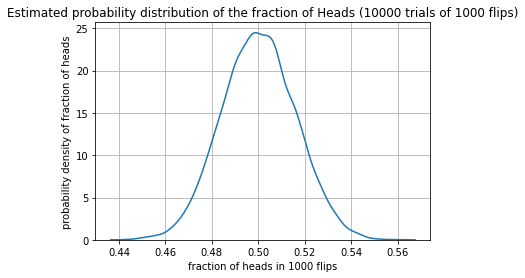

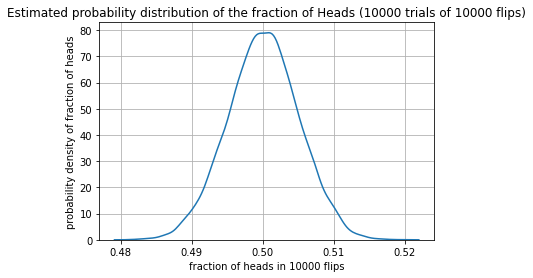

In [7]:
def buildAFlippingKDE(M, N=100, p=0.5):
    """
    Flip N coins M times and create a KDE of the distribution of flips that are "heads"
    """
    
    results=[]
    
    for i in range(M):
        results.append(flipCoins(N,p)/N)

    pl.figure()
    sns.kdeplot(results)
    pl.title("Estimated probability distribution of the fraction of Heads ({0} trials of {1} flips)".format(M, N))
    pl.xlabel("fraction of heads in {0} flips".format(N))
    pl.ylabel("probability density of fraction of heads")
    pl.grid()
    
    

#
# Let's create 3 histograms with 100, 1000, and 10000 trials
#

buildAFlippingKDE(10000,100,0.5)
buildAFlippingKDE(10000,1000,0.5)
buildAFlippingKDE(10000,10000,0.5)
    

What do you notice about these histograms? If you look carefully you'll see that the larger the number of flips the closer to 50% of the flips are heads. Does this make sense? We'll find out later exactly how this comes about and how to estimate the size of the effect mathematically. As a rule of thumb, if you *count* a number of events that are occuring randomly, the standard deviation of the count is typically something like the square root of the count. Does this rule compare reasonably with the results you see here? What do you think is the approximage PMF for this coin?

# Dictionaries to estimate PMFs

A python dictionary is a simple data structure used to track values by "key". Here's an example involving fruits. Suppose we pull 14 fruits out of a basket at random. We don't know how many of each type of fruit is *in* the basket, but suppose there's a lot (and that taking a few out doesn't significantly affect the chance of pulling out any particular type). We can use a dictionary to keep track of the types of fruit we get:

In [9]:
d={'orange':2, 'apple':5, 'grape':7}

print(d['orange'])

2


Dictionaries have some useful methods for inspecting and iterating over their contents. See examples below. Note in particular how you can use a dictionary to keep track of the counts of various categories and produce an estimated PMF based on a finite observation.

In [10]:
print("Getting keys and values from dict:\n")

print("keys:", list(d.keys()))
print("values:", list(d.values()))
print("items:",list(d.items()))

print("\nIterating through a dict's items:")
for k,v in d.items():
    print("key:",k,"value:",v)
print("\nDoing math on values (e.g., getting the sum of all values)")

num_fruits = np.array(list(d.values())).sum()
print("Total number of fruits:", num_fruits)

Getting keys and values from dict:

keys: ['orange', 'apple', 'grape']
values: [2, 5, 7]
items: [('orange', 2), ('apple', 5), ('grape', 7)]

Iterating through a dict's items:
key: orange value: 2
key: apple value: 5
key: grape value: 7

Doing math on values (e.g., getting the sum of all values)
Total number of fruits: 14


In [13]:
print("\nComputing the Fruit PMF.")

def buildPMF(dictOfThings):
    pmfDict = {}
    things = dictOfThings.items()
    numThings = np.array(list(dictOfThings.values())).sum()
    for k,v in things:
        pmfDict[k]=v/numThings

    return pmfDict

pmfD = buildPMF(d)

print("\nPMF", pmfD)


Computing the Fruit PMF.

PMF {'orange': 0.14285714285714285, 'apple': 0.35714285714285715, 'grape': 0.5}


So we have about a 14% chance of oranges, a 36% chance of apples and a 50% chance of grapes based on our small sample. Suppose we have another dict, "e":

In [14]:

e={'orange':4, 'apple':1, 'grape':12}
pmfE = buildPMF(e)

print("Another PMF:", pmfE)

Another PMF: {'orange': 0.23529411764705882, 'apple': 0.058823529411764705, 'grape': 0.7058823529411765}


# Another example of Bayesian Update

Suppose we have these two baskets "D" and "E". We secretly pick one, at random, and begin to sample fruits from the basket and record the type of fruit we see. As we inspect more and more fruits we should grow more confident as to which basket we've selected. We can use the idea of a PMF to help with this! Also, we can use a class provided by Allen Downey's [empiricaldist](https://pypi.org/project/empiricaldist/) library called "Pmf" that systemitizes this idea.



In [18]:
import empiricaldist as emp
pmfD = emp.Pmf(d)
pmfD.normalize()

pmfD

,probs
orange,0.142857
apple,0.357143
grape,0.500000


In [19]:
pmfE = emp.Pmf(e)
pmfE.normalize()

pmfE


,probs
orange,0.235294
apple,0.058824
grape,0.705882


In [20]:
pmfHypos = emp.Pmf(0.5,['D','E'])
pmfHypos

,probs
D,0.5
E,0.5


So I start with a "50/50" prior belief that it could be either bowl, equally likely.

Suppose a draw a "grape" from the bowl at random. How can I use Bayesian update to compute the posterior distribution of hypothesis? Easy, I just multiply each prior probability by the relative liklihood that it was *that* bowl given that I pulled a grape. This is a common theme! Happily the `emp.Pmf` object makes this super easy because I can simply "multiply" by any sequence-like object and it will "do the right thing".

What's the liklihood that a draw a grape if the bowl is "D"? Easy, just `pmfD['grape']`, 50%:


In [22]:
pmfD['grape']

0.5

What is the liklihood that I draw a grape if it's bowl "E"? Same idea

In [23]:
pmfE['grape']

0.7058823529411765

In [24]:
liklihood = [pmfD['grape'],pmfE['grape']]
liklihood

[0.5, 0.7058823529411765]

In [47]:
# Let's compute the posterior probability after we draw a grape:

post1 = pmfHypos*liklihood
post1

,probs
D,0.250000
E,0.352941


In [48]:
# Note that isn't normalized! We can do that easily:

post1.normalize()
post1

,probs
D,0.414634
E,0.585366


So after drawing a single grape, we have a roughly 60/40 chance that it was bowl "E". Why?

Let's systemitize that by writing a function to update the hypothesis PMF using the liklihood of measuring some data. 

In [49]:
def updateBowls(hypos, data):
    liklihood = [pmfD[data],pmfE[data]]
    post = hypos*liklihood
    post.normalize()
    return post

updateBowls(pmfHypos,'grape')
    

,probs
D,0.414634
E,0.585366


There's another handy feature of the emp.Pmf: It can sample it's own distribution.

In [50]:
samples = pmfD.choice(10)
samples

array(['grape', 'apple', 'grape', 'grape', 'grape', 'apple', 'apple',
       'apple', 'orange', 'apple'], dtype=object)

The `choice` method will draw samples from the PMF with the given probability distribution. So we can simulate drawing fruit from a particular bowl and updating the hypothesis PMF each time.

In [52]:
currentPMF = pmfHypos.copy()
for data in samples:
    currentPMF = updateBowls(currentPMF, data)

currentPMF

,probs
D,0.999208
E,0.000792


Wow! After 10 samples we are quite certain which bowl we have.

# PDFs

A PDF is similar to a PMF execept that the variable in question is continuous rather than discrete. Because of this it's not possible to say what the probability is of any specific outcome, but one must think about the probability either for a small *range* of outcome values, or in terms of a *probability* *density* (probability per unit outcome value). For example, suppose you spin a pointer that has an equal chance of stopping at any angle. You cannot say what's the chance of landing at $45^\circ$. That's zero! You *can* say the chance of landing between $44.5^\circ$ and $45.5^\circ$, that's 1/360. So the PDF would be uniform (for all angles) and equal to 1/360 *per* *degree*. PDFs do not have to be uniform (most are not!). They can have many different functional forms.

## Example:

Suppose you've been given the job of counting defects in an assembly line. You watch as parts move past you at a constant rate but you witness, at random, one defective part every 10 minutes or so. To a reasonable approximation the time between to successive defective parts is exponentially distributed (this is true of any process that has a constant averate *rate* of occurance). What would this look like?

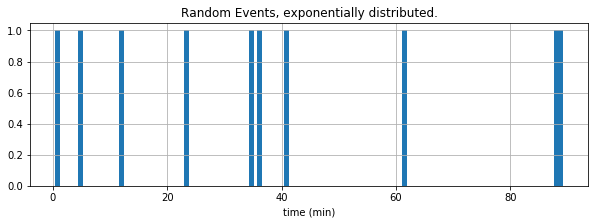

In [9]:
ax = pl.figure(figsize=(10,3))
Tau=10.0                       # mean time between defects

#
# this is how you generate 10 random events that are exponentially distributed
# with a mean time between events of "Tau". We'll learn how this works next week!
# For now, just focus on the graph and how it "looks". Don't worry, for the moment,
# about the machinery.
#

deltas =-Tau*np.log(1.0-np.random.rand(10)) 
ts = [deltas[:i].sum() for i in range(len(deltas))] 
width=ts[-1]/50
pl.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    labelleft='off') # labels along the bottom edge are off

pl.bar(np.array(ts)+width/2, 1, ts[-1]/100)
pl.title("Random Events, exponentially distributed.")
pl.xlabel("time (min)")
pl.grid()

# Probability Density Function: PDF

Another way to view this distribution is to consider the probability per unit time that the next defect comes within a certain time since the *last* defect was measured. Note the distinction here. If you don't tell me when the last defect was measured, I would have to say that the probability of a defect, per unit time (probability density), has a constant value of 0.1 per minute. However, if you say that the last defect was measured at $t=0$, *then* it turns out the probability of the *next* defect happening is *not* constant, but drops from 0.1 to 0 in an exponentially decreasing manner. The function that describes this behavior is the "Probability Density Function". Let's consider the PDF for the probability density that the next defect will occur at a time $t$ since the last defect was measured. Without proof this is:

$$
  P(t) = 
  \begin{cases}
    0 & \text{for } t \lt 0 \\
    \frac{1}{\tau} e^{-t/\tau}, & \text{for } t \geq 0
  \end{cases}
$$

where $\tau$ is the average time between defects. This should be a familiar function that ends up looking like this:

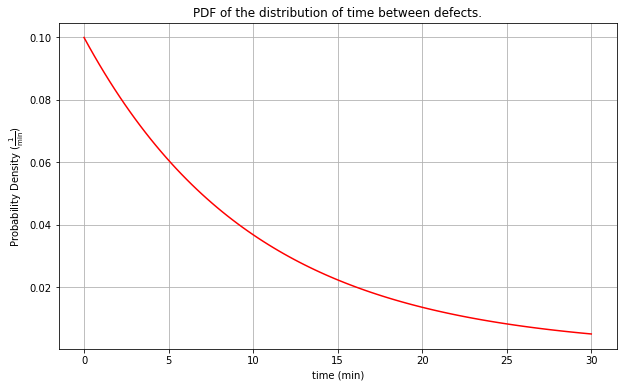

In [10]:
ax=pl.figure(figsize=(10,6))
t=np.linspace(0,30,100)        # make 100 times between 0 and 30 minutes
P=(1.0/Tau)*np.exp(-t/Tau)     # this is the corresponding PDF

pl.plot(t,P,'r-')
pl.xlabel('time (min)')
pl.ylabel(r'Probability Density (${\rm \frac{1}{min}}$)')
pl.title("PDF of the distribution of time between defects.")
pl.grid()

Because this is a "probability density function" (probability per unit time) the actual *probability* of a defect in any period of time is the product of the density multiplied by the time interval. For example, since the probability density at $t=0$ is $0.1$ *per* *minute*, the probability of a defect in the first 0.01 minutes (about 0.6 sec) is approximately:

$$ \text{Probability (between t=0 min and t=0.01 min)} \approx (0.1\, {\rm \frac{1}{min}}) \times (0.01 {\rm min}) = 0.001 $$

Of course this is a very small probability for a very small period of time. What if we want to determine the probability of a defect within the first 5 minutes (t between 0 min and 5 min)? We could carry out a similar calculation using very small periods of time and add them all together, or we could use calculus and integrate to find the sum:

$$ \text{Probability (between t=0 min and t=5 min)} = \int_{t={\rm 0\ min}}^{t={\rm 5\ min}} P(t)\,dt $$

Actually, looking at the graph we can simply *see* this will be about:

$$ \text{Probability (between t=0 min and t=5 min)} \approx (0.08\, {\rm \frac{1}{min}})\times (5 {\rm min}) \approx 0.4$$

Or we can work it out exactly:


$$ \text{Probability (between t=0 min and t=5 min)} = \int_{t={\rm 0\ min}}^{t={\rm 5\ min}} \frac{1}{\tau} e^{-t/\tau}\,dt $$

$$ \text{Probability (between t=0 min and t=5 min)} = (1 - e^{-{\rm (5\,min)}/{\rm (10\,min)}}) = (1-e^{-1/2}) = 0.3935$$

So our "guess" of 0.4 is actually pretty darn close! What's the chance of seeing zero defects in the first 5 minutes? Well since we either see one (or more), or we see zero, so the chance of seeing zero must be 

$$\text{Probability of zero defects (between t=0 min and t=5 min)}\approx 1.0-0.4 \approx 0.6 $$

These two probabilities (the chance of seeing one or more, and the chance of seeing zero) always add up to one. As time goes on the probability of seeing at least one defect approaches certainty (1.0) while the probabilty of seeing zero falls to zero. Because the probability of measuring a $t$ less that a specific value turns up so much in practice, we give that function a special name. It's called the "Cumulative Distribution Function" or "CDF".

# Cumulative Distribution Function (CDF)

The CDF is the probability that $t$ is less than some specific value. Note that a) We have to shuffle the variables a bit here to be clear mathematically. The variable of *integration* needs to have a different label that the limits of integration, so we'll use $t'$ inside the integral and $t$ for the CDF, b) since our example PDF has no meaning for $t<0$ we *define* it to be zero for those values of $t$. Other PDFs may be perfectly well defined for negative values of their independent variable, so the limit of $-\infty$ makes sense.

$$\text{CDF(t) = Probability (between $t'=-\infty$ and $t'=t$)} = \int_{-\infty}^{t} P(t')\,dt'$$

In our example of defect counting, the CDF becomes:

$$ \text{CDF(t) = Probability (between $t'=-\infty$ and $t'=t$)} = (1 - e^{-t/\tau}) $$

If we graph this function we can visualize the CDF directly:

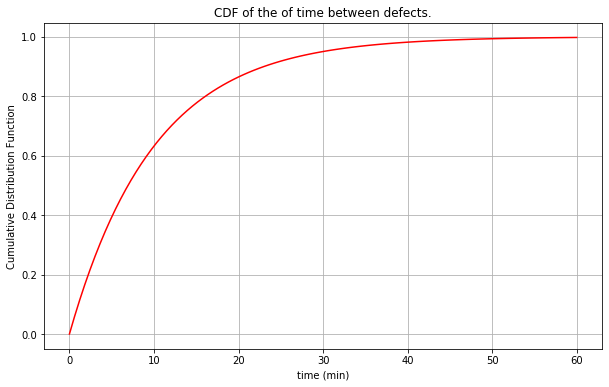

In [11]:
ax=pl.figure(figsize=(10,6))
t=np.linspace(0,60,100)        # make 100 times between 0 and 30 minutes
CDF=1-np.exp(-t/Tau)           # this is the corresponding CDF

pl.plot(t,CDF,'r-')
pl.xlabel('time (min)')
pl.ylabel(r'Cumulative Distribution Function')
pl.title("CDF of the of time between defects.")
pl.grid()

One clear advantage of a CDF is that you can read *probabilities* right off the graph. For example, from this we can see that there's close to a 90% chance that you'll see at least one defect within 20 min of the last one. So that's a handy way to summarize the results.

# Expectation Values

So assuming you have a particular PDF suppose you measure a bunch of times between defects. What would you expect for the average time? This sounds like a hard question, but it turns out it's not so bad. Suppose you measured the time between 1000 defects and recorded them all. You might end up with a bunch of numbers (in minutes) like this:

In [12]:
print(', '.join(["%5.2f" % x for x in deltas]),'...')

 4.00,  7.07, 11.38, 11.37,  1.38,  4.82, 20.64, 26.59,  0.58, 13.71 ...


To get the average time you could just add these together and divide by 1000. That's a lot of work! Can we use the PDF to estimate the result of such an experiment? You bet!

How many of these results would you *expect* to fall between $t=0$ and $t=1$ min based on the PDF? Easy! Get the probability that you see a defect in the first minute, and multiply by 1000:

$$ \text{N (between $t=0$ and $t = 1$ min)} \approx 1000\times P(0.5)\times 1\,{\rm min} \approx 95$$

How about in the second minute? Same idea, but using $P(1.5)$:

$$ \text{N (between $t=1$ and $t = 2$ min)} \approx 1000\times P(1.5)\times 1\,{\rm min} \approx 86$$

and the third minute:

$$ \text{N (between $t=2$ and $t = 3$ min)} \approx 1000\times P(2.5)\times 1\,{\rm min} \approx 77$$

and so on. To estimate the sum above take the number from the first minute and multiply by 0.5 min (on the average). Then take the number from the second minute and multiply by 1.5 min (again, on the average). Repeat this for every interval. Then divide by 1000. That's an *estimated* value we expect: or *expectation* value.

Note that while we can clearly perform this process computationally, we can also do it analytically using calculus.

$$\langle t \rangle = \int_{-\infty}^\infty P(t)\,t\, dt$$

# Exercises

Exercise 1: I have three multi-sided dice. One four sided, one six sided, and one eight sided. I pick one at random and begin rolling. Suppose I get the following results: 1, 4, 2, 5. What are the probabilities that I have the four, the six, or the eight sided die? Use Bayesian update! 

Exercise 2: Using the defect distribution above, estimate the probability that you'll see a defect between $t=4.5\,{\rm min}$ and $t=5.5\,{\rm min}$ after the last defect was observed. Explain how you arrived at your answer.

Exercise 3: Show, using calculus, that the expectation value of $t$ is just $\tau$.